# Test tiger with simple linear regression

In [16]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger 
import tigerpy.bbvi as bbvi

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd

rng = np.random.default_rng(42)

## Simulate data

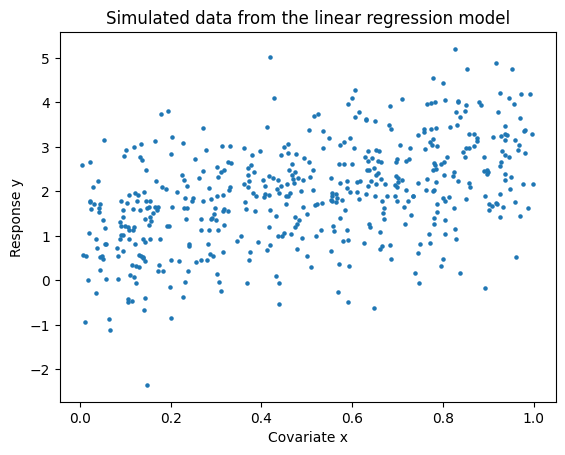

In [17]:
# sample size and true parameters

n = 500
true_beta = np.array([1.0, 2.0])
true_sigma = 1.0

# data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
eps = rng.normal(scale=true_sigma, size=n)
response_vec = X_mat @ true_beta + eps

# plot the simulated data

plt.scatter(x0, response_vec, s = 5)
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [18]:
# set up design matrix 
X = tiger.Obs(name = "X")
X.fixed(data = x0)

# set up hyperparameters
beta_loc = tiger.Hyper(0, name="beta_loc")
beta_scale = tiger.Hyper(100, name="beta_scale")

# set up parameters
beta_dist = tiger.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# set up hyperparameters for the scale
sigma_a = tiger.Hyper(0.01, name="a")
sigma_b = tiger.Hyper(0.01, name="b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)

# use function jax.numpy.exp for transformation to correct parameter space
sigma = tiger.Param(value=jnp.log(10.0), distribution=sigma_dist, function=jnp.exp, name="sigma")

# set up the linear predictor
lpred = tiger.Lpred(Obs=X, beta=beta)

# set up response distribution
response_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [19]:
jnp.sum(m.log_lik)

Array(-1623.414, dtype=float32)

In [20]:
m.log_prior

Array(-18.020359, dtype=float32)

In [21]:
m.log_prob

Array(-1641.4343, dtype=float32)

In [14]:
graph = tiger.ModelGraph(Model=m)
graph.build_graph()

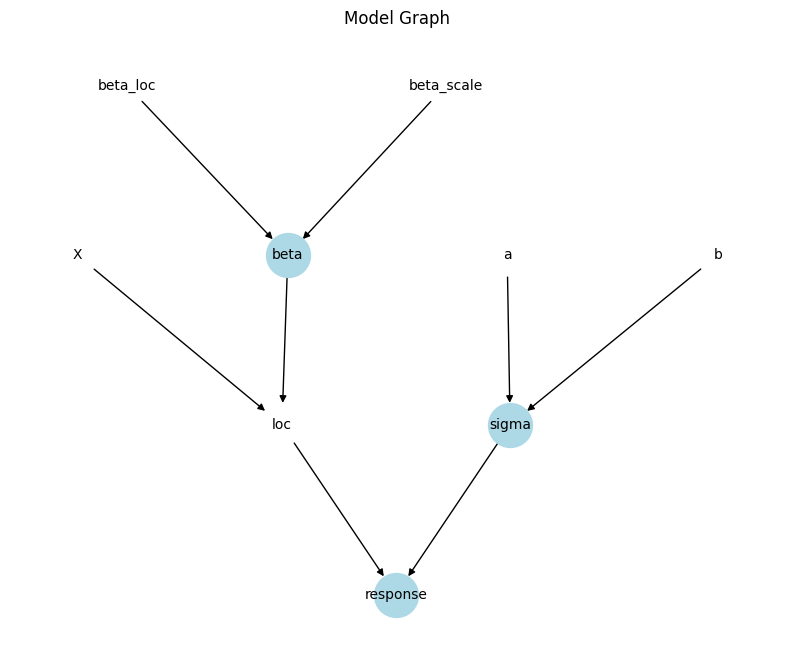

In [15]:
graph.visualize_graph()

## Inference with BBVI

In [12]:
q = bbvi.Bbvi(Graph=graph, num_samples=64, num_iterations=10000, key=27)

In [13]:
q.run_bbvi(step_size=0.01, threshold=1e-5, chunk_size=25)

(Array(-739.4668, dtype=float32),
 {'beta': {'mu': Array([0.9828227, 1.9105289], dtype=float32),
   'cov': Array([[ 0.00951545, -0.01579689],
          [-0.01579689,  0.03446265]], dtype=float32)},
  'sigma': {'mu': Array([0.02606021], dtype=float32),
   'cov': Array([[0.000897]], dtype=float32)}})

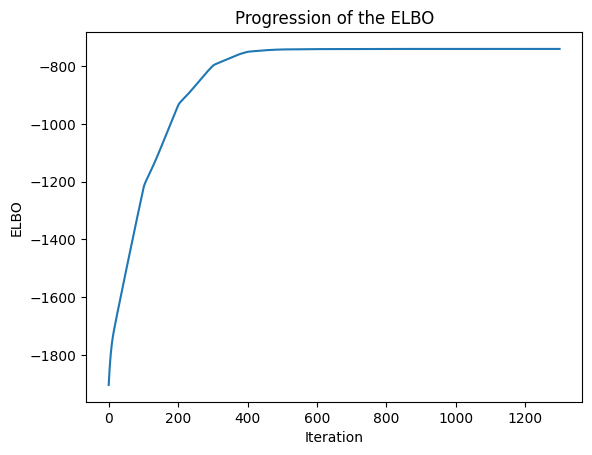

In [14]:
q.plot_elbo()